# Analysis, Robustness, and Interpretability (EuroSAT)

This notebook compares three models on EuroSAT:

* RGB baseline (ResNet18)

* Multispectral baseline (13-band ResNet18)

* Physics-aware multispectral model

We evaluate accuracy, per-class confusion matrices, and robustness to noise / band dropout

---

In [2]:
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import torch
import torch.nn as nn

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
sys.path.append(str(PROJECT_ROOT))
from src.models_physics import PhysicsAwareResNet18
DATA_DIR = PROJECT_ROOT / "data"
SPLITS_DIR = PROJECT_ROOT / "splits"
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [3]:
from torchvision.datasets import EuroSAT
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

rgb_splits = np.load(SPLITS_DIR / "eurosat_rgb_splits.npz")
train_idx_rgb, val_idx_rgb, test_idx_rgb = rgb_splits["train_idx"], rgb_splits["val_idx"], rgb_splits["test_idx"]

rgb_tf = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])
ds_rgb = EuroSAT(root=str(DATA_DIR / "eurosat_rgb"), download=False, transform=rgb_tf)

test_rgb = Subset(ds_rgb, test_idx_rgb)
test_rgb_loader = DataLoader(test_rgb, batch_size=128, shuffle=False, num_workers=0)

class_names = ds_rgb.classes
num_classes = len(class_names)

In [4]:
from torchgeo.datasets import EuroSAT as EuroSAT_MS
from torch.utils.data import Dataset

ms_splits = np.load(SPLITS_DIR / "eurosat_ms_splits.npz")
train_idx_ms, val_idx_ms, test_idx_ms = ms_splits["train_idx"], ms_splits["val_idx"], ms_splits["test_idx"]

norm = torch.load(ARTIFACTS_DIR / "eurosat_ms_norm.pt")
ms_mean, ms_std = norm["mean"].float(), norm["std"].float()

ds_ms = EuroSAT_MS(root=str(DATA_DIR / "eurosat_ms"), download=False)

class MSNorm(Dataset):
    def __init__(self, base, idxs):
        self.base, self.idxs = base, idxs
    def __len__(self): return len(self.idxs)
    def __getitem__(self, i):
        it = self.base[int(self.idxs[i])]
        x = (it["image"].float() - ms_mean[:,None,None]) / ms_std[:,None,None]
        return x, int(it["label"])

test_ms = MSNorm(ds_ms, test_idx_ms)
test_ms_loader = DataLoader(test_ms, batch_size=64, shuffle=False, num_workers=0)

In [7]:
from torchvision import models

def rgb_model():
    m = models.resnet18(weights=None)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def ms_model():
    m = models.resnet18(weights=None)
    m.conv1 = nn.Conv2d(13,64,7,2,3,bias=False)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

rgb = rgb_model().to(device)
ms  = ms_model().to(device)

rgb.load_state_dict(torch.load(ARTIFACTS_DIR / "rgb_resnet18_best.pt", map_location="cpu"))
ms.load_state_dict(torch.load(ARTIFACTS_DIR / "ms_resnet18_best.pt", map_location="cpu"))

rgb.eval(); ms.eval()

ResNet(
  (conv1): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [8]:
BAND_GROUPS = {
    "VIS":  [0, 1, 2],          # visible
    "RE":   [3, 4, 5],          # red-edge
    "NIR":  [6, 7],             # near infrared
    "SWIR": [8, 9, 10, 11, 12]  # short-wave infrared
}

physics = PhysicsAwareResNet18(BAND_GROUPS, num_classes).to(device)
physics.load_state_dict(torch.load(ARTIFACTS_DIR / "physics_aware_best.pt", map_location="cpu"))
physics.eval()

PhysicsAwareResNet18(
  (stem): PhysicsAwareStem(
    (branches): ModuleDict(
      (VIS): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
      (RE): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
   

In [9]:
@torch.no_grad()
def predict_all(model, loader):
    ys, ps = [], []
    for x,y in loader:
        x = x.to(device)
        ps.append(model(x).argmax(1).cpu().numpy())
        ys.append(np.asarray(y))
    return np.concatenate(ys), np.concatenate(ps)

def acc(y,p): return float((y==p).mean())

def cm(y,p,k):
    m = np.zeros((k,k),int)
    for t,p_ in zip(y,p): m[t,p_]+=1
    return m

In [10]:
yr, pr = predict_all(rgb, test_rgb_loader)
ym, pm = predict_all(ms, test_ms_loader)
yp, pp = predict_all(physics, test_ms_loader)

acc(yr,pr), acc(ym,pm), acc(yp,pp)

(0.7570370370370371, 0.9259259259259259, 0.9469135802469136)

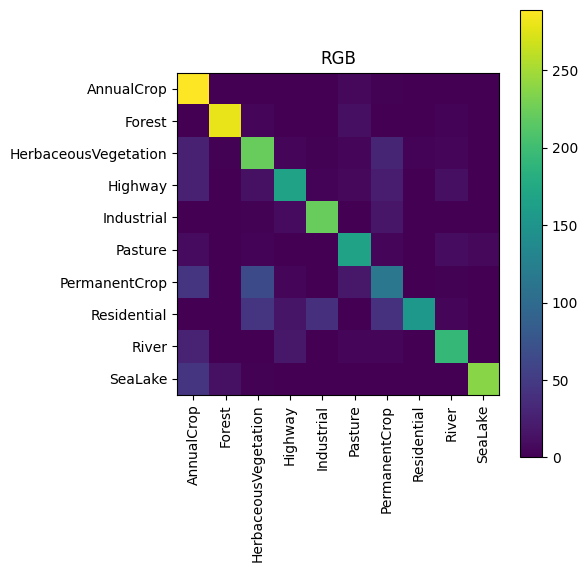

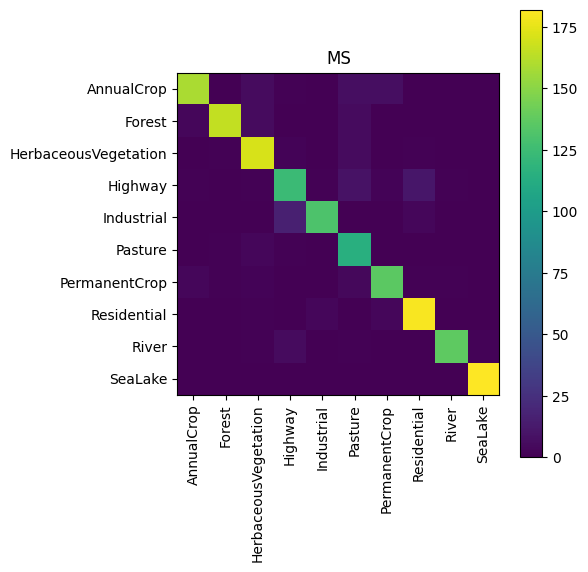

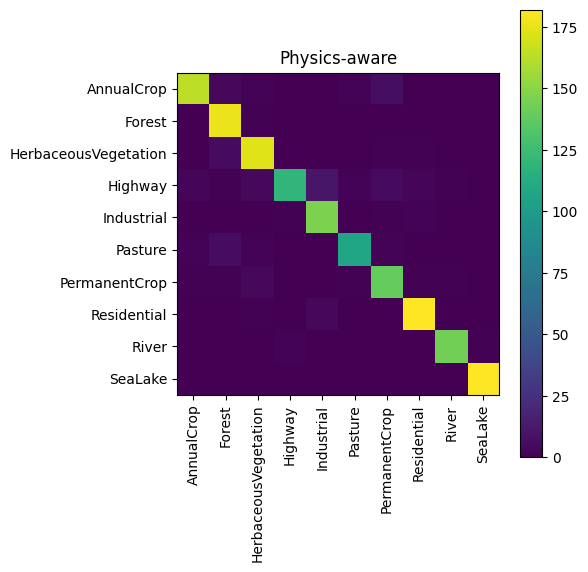

In [11]:
def plot(cm,title):
    plt.figure(figsize=(6,6))
    plt.imshow(cm); plt.title(title)
    plt.xticks(range(num_classes), class_names, rotation=90)
    plt.yticks(range(num_classes), class_names)
    plt.colorbar(); plt.tight_layout(); plt.show()

plot(cm(yr,pr,num_classes),"RGB")
plot(cm(ym,pm,num_classes),"MS")
plot(cm(yp,pp,num_classes),"Physics-aware")

In [14]:
BAND_GROUPS = {
    "VIS":[0,1,2],
    "RE":[3,4,5],
    "NIR":[6,7],
    "SWIR":[8,9,10,11,12]
}

def drop_bands(x, idxs):
    x = x.clone()
    x[:, idxs, :, :] = 0.0
    return x

@torch.no_grad()
def eval_drop(model, base_ds, idxs, batch_size=64):
    class W(Dataset):
        def __init__(self, ds, drop_idxs):
            self.ds = ds
            self.drop_idxs = drop_idxs
        def __len__(self):
            return len(self.ds)
        def __getitem__(self, i):
            x, y = self.ds[i]              # x: [13, H, W]
            x = drop_bands(x.unsqueeze(0), self.drop_idxs).squeeze(0)
            return x, y

    loader = DataLoader(W(base_ds, idxs), batch_size=batch_size, shuffle=False, num_workers=0)
    y_true, y_pred = predict_all(model, loader)
    return acc(y_true, y_pred)

for name, idxs in BAND_GROUPS.items():
    print(f"Drop {name:4s} | MS acc={eval_drop(ms, test_ms, idxs):.3f} | PA acc={eval_drop(physics, test_ms, idxs):.3f}")


Drop VIS  | MS acc=0.724 | PA acc=0.552
Drop RE   | MS acc=0.690 | PA acc=0.849
Drop NIR  | MS acc=0.601 | PA acc=0.473
Drop SWIR | MS acc=0.389 | PA acc=0.815


In [15]:
import json
summary={"rgb":acc(yr,pr),"ms":acc(ym,pm),"physics":acc(yp,pp)}
with open(ARTIFACTS_DIR/"notebook05_summary.json","w") as f:
    json.dump(summary,f,indent=2)
summary

{'rgb': 0.7570370370370371,
 'ms': 0.9259259259259259,
 'physics': 0.9469135802469136}